# **1. Imports & Global Parameters**

In [2]:
import os
import pickle
import numpy as np
import pandas as pd
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report, f1_score, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, BatchNormalization, Dropout, Flatten, Dense, Input, GlobalAveragePooling1D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.utils import resample, shuffle
from sklearn.utils.class_weight import compute_class_weight

# Global parameters
DATASET_DIR = r"/kaggle/input/wesad-full-dataset/WESAD"
WINDOW_SECONDS = 5
FS = 700
WINDOW_SIZE = WINDOW_SECONDS * FS  # 3500
NUM_CHANNELS = 8  # ECG, EDA, EMG, Resp, Temp, ACCx, ACCy, ACCz

# **2. Load All .pkl Files into Memory**

In [3]:
wesad_data = {}
for subj in os.listdir(DATASET_DIR):
    subj_path = os.path.join(DATASET_DIR, subj)
    if not os.path.isdir(subj_path):
        continue
    for fname in os.listdir(subj_path):
        if fname.endswith('.pkl'):
            with open(os.path.join(subj_path, fname), 'rb') as f:
                data = pickle.load(f, encoding='latin1')
            wesad_data[subj] = data

print("Loaded subjects:", list(wesad_data.keys()))

Loaded subjects: ['S14', 'S11', 'S13', 'S10', 'S8', 'S5', 'S7', 'S9', 'S15', 'S2', 'S6', 'S3', 'S4', 'S16', 'S17']


# **3. Build a Single DataFrame from Chest Signals**

In [4]:
data_list = []
for subj, data in wesad_data.items():
    chest = data['signal']['chest']
    labels = data['label'].flatten()
    n = len(chest['ECG'].flatten())
    df_ch = pd.DataFrame({
        'ECG':   chest['ECG'].flatten(),
        'EDA':   chest['EDA'].flatten(),
        'EMG':   chest['EMG'].flatten(),
        'TEMP':  chest['Temp'].flatten(),
        'RESP':  chest['Resp'].flatten(),
        'ACC_X': chest['ACC'][:, 0].flatten(),
        'ACC_Y': chest['ACC'][:, 1].flatten(),
        'ACC_Z': chest['ACC'][:, 2].flatten(),
        'Label': labels[:n]
    })
    df_ch['Subject'] = subj
    data_list.append(df_ch)

df = pd.concat(data_list, ignore_index=True)
df.head()

,ECG,EDA,EMG,TEMP,RESP,ACC_X,ACC_Y,ACC_Z,Label,Subject
0,-0.170883,2.738953,0.010117,32.824799,-1.330566,0.7654,-0.1888,0.3714,0,S14
1,-0.152618,2.727127,0.011948,32.824799,-1.316833,0.7160,-0.2296,0.3950,0,S14
2,-0.131973,2.740097,0.023758,32.809814,-1.292419,0.6840,-0.2580,0.3934,0,S14
3,-0.118790,2.739334,0.004715,32.776855,-1.271057,0.6648,-0.2792,0.3672,0,S14
4,-0.111740,2.729034,0.003525,32.823303,-1.258850,0.6562,-0.2898,0.3262,0,S14


# **4. Filter & Map to Binary Stress Label**

In [5]:
df_filtered = df[df['Label'].isin([1, 2, 3, 4])].copy()
label_map = {1: 0, 2: 1, 3: 0, 4: 0}
df_filtered['Binary_Label'] = df_filtered['Label'].map(label_map)
df_filtered.drop(columns='Label', inplace=True)
df_filtered['Binary_Label'].value_counts()

Binary_Label
0    24494402
1     6976201
Name: count, dtype: int64

## **Visualize Class Distribution**

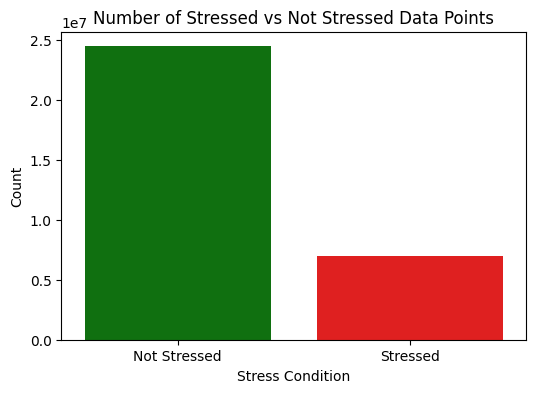

In [6]:
plt.figure(figsize=(6, 4))
ax = sns.countplot(
    data=df_filtered,
    x="Binary_Label",
    hue="Binary_Label",
    palette=["green", "red"],
    dodge=False
)
ax.legend_.remove()
plt.xticks([0, 1], ["Not Stressed", "Stressed"])
plt.title("Number of Stressed vs Not Stressed Data Points")
plt.xlabel("Stress Condition")
plt.ylabel("Count")
plt.show()

## **Plot an Example ECG Signal**

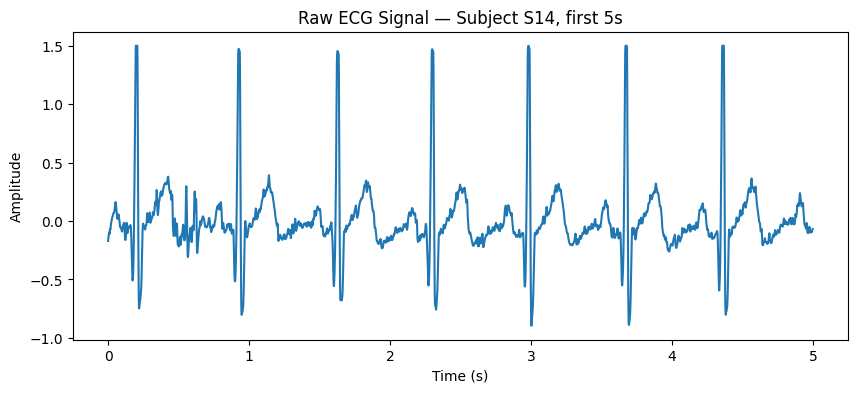

In [7]:
# pick first subject and first WINDOW_SECONDS of ECG
subj0 = list(wesad_data.keys())[0]
ecg = wesad_data[subj0]['signal']['chest']['ECG'].flatten()
t = np.arange(len(ecg)) / FS

plt.figure(figsize=(10, 4))
plt.plot(t[:WINDOW_SIZE], ecg[:WINDOW_SIZE])
plt.title(f'Raw ECG Signal — Subject {subj0}, first {WINDOW_SECONDS}s')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.show()

## **Visualize Frequency Spectrum of an Example ECG Window**

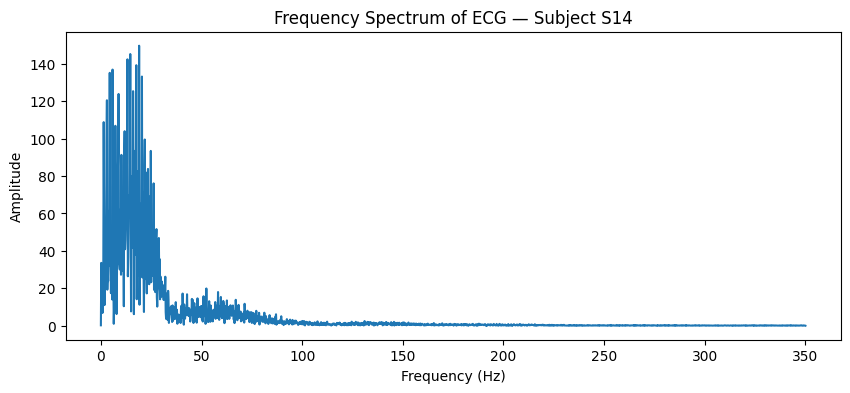

In [8]:
# pick the same first WINDOW_SECONDS of ECG we plotted before
window_ecg = ecg[:WINDOW_SIZE]

# compute FFT
fft_vals = np.fft.rfft(window_ecg)
freqs = np.fft.rfftfreq(WINDOW_SIZE, d=1/FS)

plt.figure(figsize=(10,4))
plt.plot(freqs, np.abs(fft_vals))
plt.title(f'Frequency Spectrum of ECG — Subject {subj0}')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude')
plt.show()

# **5. Data Segmentation Functions**

In [9]:
def segment_data_raw(data_dict):
    X, y = [], []
    if 'signal' not in data_dict or 'label' not in data_dict:
        return np.array([]), np.array([])
    chest = data_dict['signal']['chest']
    total_samples = len(next(iter(chest.values())))
    num_windows = total_samples // WINDOW_SIZE
    for i in range(num_windows):
        start = i * WINDOW_SIZE
        end = start + WINDOW_SIZE
        window_data, label = get_window(chest, data_dict['label'], start, end)
        if window_data is not None:
            X.append(window_data)
            y.append(label)
    return np.array(X), np.array(y)

def get_window(chest, label_arr, start, end):
    def get_signal(key):
        s = np.array(chest.get(key, np.zeros(WINDOW_SIZE))[start:end]).ravel()
        if len(s) < WINDOW_SIZE:
            s = np.pad(s, (0, WINDOW_SIZE - len(s)))
        return s

    try:
        ECG  = get_signal('ECG')
        EDA  = get_signal('EDA')
        EMG  = get_signal('EMG')
        Resp = get_signal('Resp')
        Temp = get_signal('Temp')
        acc  = np.array(chest.get('ACC', np.zeros((WINDOW_SIZE, 3)))[start:end])
        if acc.ndim == 2 and acc.shape[1] == 3:
            ACC_x, ACC_y, ACC_z = acc[:,0], acc[:,1], acc[:,2]
        else:
            ACC_x = ACC_y = ACC_z = np.zeros(WINDOW_SIZE)

        signals = [ECG, EDA, EMG, Resp, Temp, ACC_x, ACC_y, ACC_z]
        window_data = np.stack(signals, axis=-1)
        mode_label = int(stats.mode(label_arr[start:end], keepdims=True).mode[0])
        return window_data, mode_label
    except Exception as e:
        print(f"Error at window {start}: {e}")
        return None, None

# **6. Subject-Level Preprocessing & Scaling**

In [10]:
def filter_map_labels_binary(X, y):
    valid = np.isin(y, [1, 2, 3, 4])
    X, y = X[valid], y[valid]
    mapping = {1:0, 2:1, 3:0, 4:0}
    y_mapped = np.array([mapping[val] for val in y])
    return X[:len(y_mapped)], y_mapped

def load_subject_data(folder):
    files = [f for f in os.listdir(folder) if f.endswith('.pkl')]
    if not files:
        return np.array([]), np.array([])
    try:
        with open(os.path.join(folder, files[0]), 'rb') as f:
            data = pickle.load(f, encoding='latin1')
        return segment_data_raw(data)
    except Exception as e:
        print(f"Skip {folder}: {e}")
        return np.array([]), np.array([])

def load_and_scale_all_data():
    X_list, y_list = [], []
    for subj in sorted(os.listdir(DATASET_DIR)):
        path = os.path.join(DATASET_DIR, subj)
        if not os.path.isdir(path):
            continue
        print("Processing:", subj)
        X_sub, y_sub = load_subject_data(path)
        if X_sub.size == 0:
            continue
        X_sub, y_sub = filter_map_labels_binary(X_sub, y_sub)
        flat = X_sub.reshape(X_sub.shape[0], -1)
        scaled = StandardScaler().fit_transform(flat).astype(np.float32)
        X_list.append(scaled.reshape(-1, WINDOW_SIZE, NUM_CHANNELS))
        y_list.append(y_sub)
    if not X_list:
        return None, None
    return np.vstack(X_list), np.concatenate(y_list)

## **Visual Comparison of ECG — Stressed vs. Not Stressed**

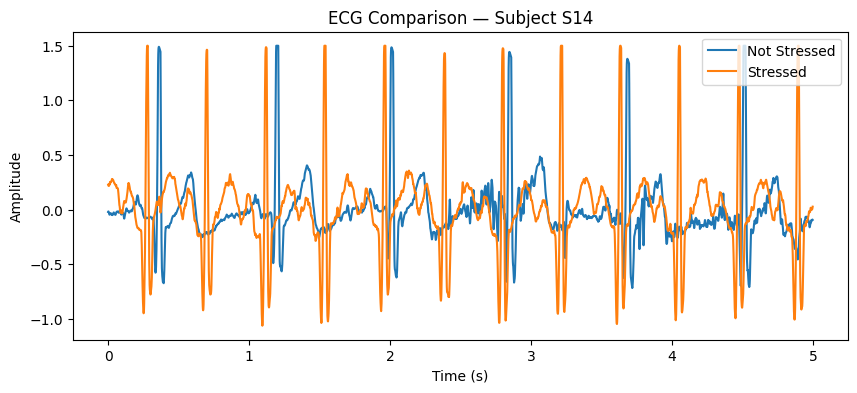

In [11]:
# 1) Segment raw data & labels for the first subject
raw_windows, raw_labels = segment_data_raw(wesad_data[subj0])

# 2) Filter & map to binary, then extract only the ECG channel (channel 0)
X_w, y_w = filter_map_labels_binary(raw_windows, raw_labels)
ecg_windows = X_w[:, :, 0]  # shape: (n_windows, WINDOW_SIZE)

# 3) Pick the first non-stress and first stress window
idx_non = np.where(y_w == 0)[0][0]
idx_str = np.where(y_w == 1)[0][0]

# 4) Plot both ECG waveforms over the same time axis
t = np.arange(WINDOW_SIZE) / FS
plt.figure(figsize=(10, 4))
plt.plot(t, ecg_windows[idx_non], label='Not Stressed')
plt.plot(t, ecg_windows[idx_str], label='Stressed')
plt.title(f'ECG Comparison — Subject {subj0}')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.legend()
plt.show()

# **7. Train/Test Split**

In [12]:
X_all, y_all = load_and_scale_all_data()
if X_all is None:
    raise RuntimeError("No data loaded")

print("All windows:", X_all.shape[0])
print("Label counts:", dict(zip(*np.unique(y_all, return_counts=True))))

X_train, X_test, y_train, y_test = train_test_split(
    X_all, y_all, test_size=0.3, random_state=42, shuffle=True
)

Processing: S10
Processing: S11
Processing: S13
Processing: S14
Processing: S15
Processing: S16
Processing: S17
Processing: S2
Processing: S3
Processing: S4
Processing: S5
Processing: S6
Processing: S7
Processing: S8
Processing: S9
All windows: 8995
Label counts: {0: 7002, 1: 1993}


# **8. Build & Compile 1D-CNN**

In [25]:
def build_1d_cnn_binary(input_shape):
    return Sequential([
        Input(shape=input_shape),

        Conv1D(32, 7, activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling1D(2),
        
        Conv1D(64, 5, activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling1D(2),

        Conv1D(128, 3, activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling1D(2),

        GlobalAveragePooling1D(),
        Dropout(0.4),

        Dense(64, activation='relu'),
        Dropout(0.3),

        Dense(1, activation='sigmoid')
    ])

model = build_1d_cnn_binary((WINDOW_SIZE, NUM_CHANNELS))
model.compile(optimizer=Adam(5e-4), loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_9 (Conv1D)                    │ (None, 3500, 32)            │           1,824 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_9                │ (None, 3500, 32)            │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_9 (MaxPooling1D)       │ (None, 1750, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_10 (Conv1D)                   │ (None, 1750, 64)            │          10,304 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_10               │ (None, 1750, 64)            │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_10 (MaxPooling1D)      │ (None, 875, 64)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_11 (Conv1D)                   │ (None, 875, 128)            │          24,704 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_11               │ (None, 875, 128)            │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_11 (MaxPooling1D)      │ (None, 437, 128)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling1d_3           │ (None, 128)                 │               0 │
│ (GlobalAveragePooling1D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 46,049 (179.88 KB)

 Trainable params: 45,601 (178.13 KB)

 Non-trainable params: 448 (1.75 KB)

# **9. Train the Model**

In [26]:
class_weights = dict(enumerate(
    compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
))
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history = model.fit(
    X_train, y_train,
    epochs=20,
    batch_size=64,
    validation_split=0.2,
    class_weight=class_weights,
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 14s 91ms/step - accuracy: 0.8230 - loss: 0.3266 - val_accuracy: 0.9349 - val_loss: 0.3839
Epoch 2/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - accuracy: 0.9342 - loss: 0.1572 - val_accuracy: 0.9405 - val_loss: 0.1918
Epoch 3/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - accuracy: 0.9558 - loss: 0.1153 - val_accuracy: 0.9659 - val_loss: 0.1083
Epoch 4/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - accuracy: 0.9584 - loss: 0.1053 - val_accuracy: 0.9794 - val_loss: 0.0643
Epoch 5/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - accuracy: 0.9664 - loss: 0.0846 - val_accuracy: 0.9778 - val_loss: 0.0587
Epoch 6/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - accuracy: 0.9698 - loss: 0.0762 - val_accuracy: 0.9817 - val_loss: 0.0514
Epoch 7/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - accuracy: 0.9752 - loss: 0.0587 - val_accuracy: 0.9865 - val_loss: 0.0543
Epoch 8/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - accuracy: 0.9813 - loss: 0.0493 - val_accuracy: 0.9865 - 

# **10. Visualize Training Curves**

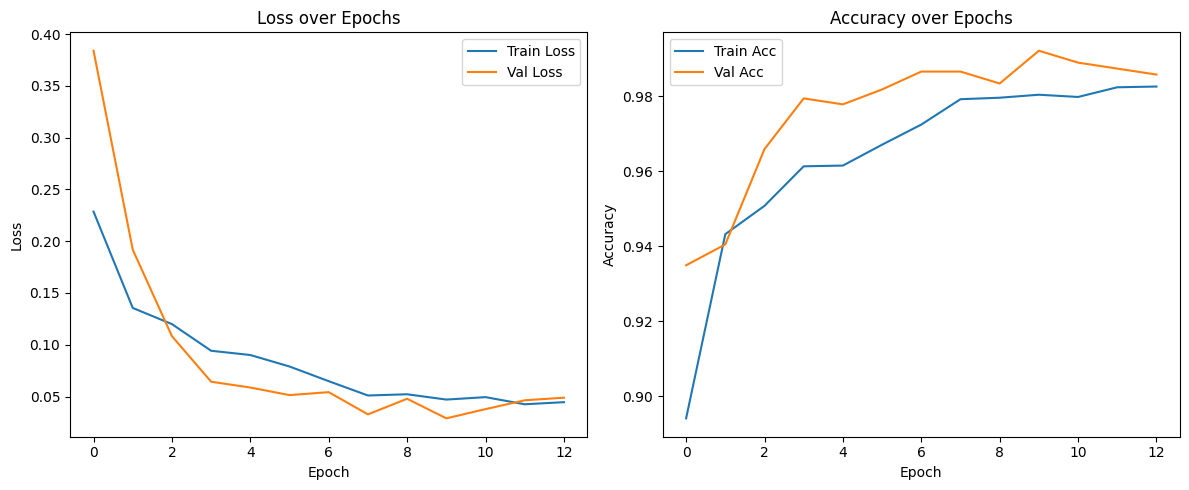

In [27]:
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

# **11. Threshold Tuning**

In [28]:
y_probs = model.predict(X_test)
thresholds = np.arange(0.5, 1.0, 0.05)
best_thresh, best_f1 = 0.5, 0.0

for t in thresholds:
    preds = (y_probs > t).astype(int)
    score = f1_score(y_test, preds)
    if score > best_f1:
        best_f1, best_thresh = score, t

print(f"Best thresh: {best_thresh:.2f}, F1: {best_f1:.3f}")

85/85 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step
Best thresh: 0.70, F1: 0.980


# **12. Final Evaluation & Confusion Matrix**

Classification Report:
              precision    recall  f1-score   support

  Non-Stress       1.00      0.99      0.99      2097
      Stress       0.98      0.99      0.98       602

    accuracy                           0.99      2699
   macro avg       0.99      0.99      0.99      2699
weighted avg       0.99      0.99      0.99      2699



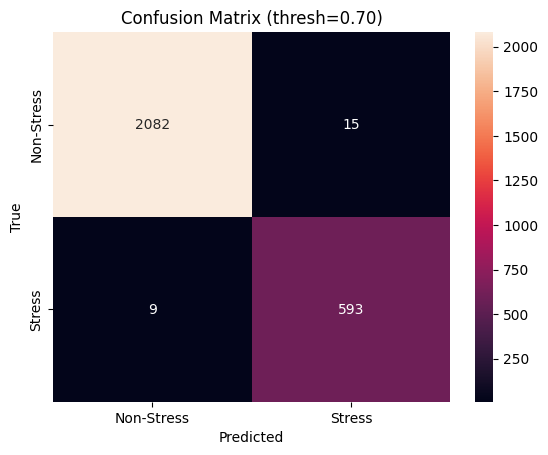

In [29]:
y_pred = (y_probs > best_thresh).astype(int)

print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=["Non-Stress","Stress"]))

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='rocket',
            xticklabels=["Non-Stress","Stress"],
            yticklabels=["Non-Stress","Stress"])
plt.title(f"Confusion Matrix (thresh={best_thresh:.2f})")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# **13. Save the Model**

In [30]:
model.save("final_binary_1dcnn_class_weights.h5")
print("Model saved to Binary_1DCNN_Class_Weights.h5")

Model saved to Binary_1DCNN_Class_Weights.h5


# **14. Testing the Model by Resampling Balanced Data from the Test Set**

In [31]:
# Separate classes in test set
X_test_nonstress = X_test[y_test == 0]
X_test_stress = X_test[y_test == 1]

# Downsample the majority class
if len(X_test_nonstress) > len(X_test_stress):
    X_ns_down, y_ns_down = resample(
        X_test_nonstress, np.zeros(len(X_test_nonstress)), 
        replace=False, n_samples=len(X_test_stress), random_state=42
    )
    X_test_balanced = np.concatenate([X_ns_down, X_test_stress])
    y_test_balanced = np.concatenate([y_ns_down, np.ones(len(X_test_stress))])
else:
    X_s_down, y_s_down = resample(
        X_test_stress, np.ones(len(X_test_stress)), 
        replace=False, n_samples=len(X_test_nonstress), random_state=42
    )
    X_test_balanced = np.concatenate([X_test_nonstress, X_s_down])
    y_test_balanced = np.concatenate([np.zeros(len(X_test_nonstress)), y_s_down])

# Shuffle the balanced test set
X_test_balanced, y_test_balanced = shuffle(X_test_balanced, y_test_balanced, random_state=42)

38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step
Classification Report (Balanced Test Set):
              precision    recall  f1-score   support

  Non-Stress       0.99      0.99      0.99       602
      Stress       0.99      0.99      0.99       602

    accuracy                           0.99      1204
   macro avg       0.99      0.99      0.99      1204
weighted avg       0.99      0.99      0.99      1204



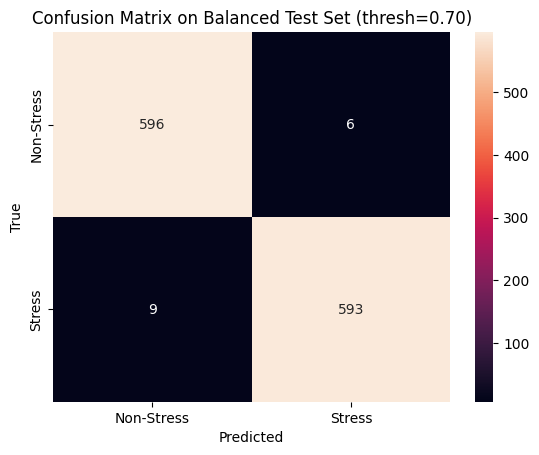

In [32]:
# Predict with the same trained model
y_probs_balanced = model.predict(X_test_balanced)
y_pred_balanced = (y_probs_balanced > best_thresh).astype(int)

#Print classification report and plot confusion matrix
print("Classification Report (Balanced Test Set):")
print(classification_report(y_test_balanced, y_pred_balanced, target_names=["Non-Stress", "Stress"]))

cm = confusion_matrix(y_test_balanced, y_pred_balanced)
sns.heatmap(cm, annot=True, fmt='d', cmap='rocket',
            xticklabels=["Non-Stress", "Stress"],
            yticklabels=["Non-Stress", "Stress"])
plt.title(f"Confusion Matrix on Balanced Test Set (thresh={best_thresh:.2f})")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# **Plotting the ROC Curve**

85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


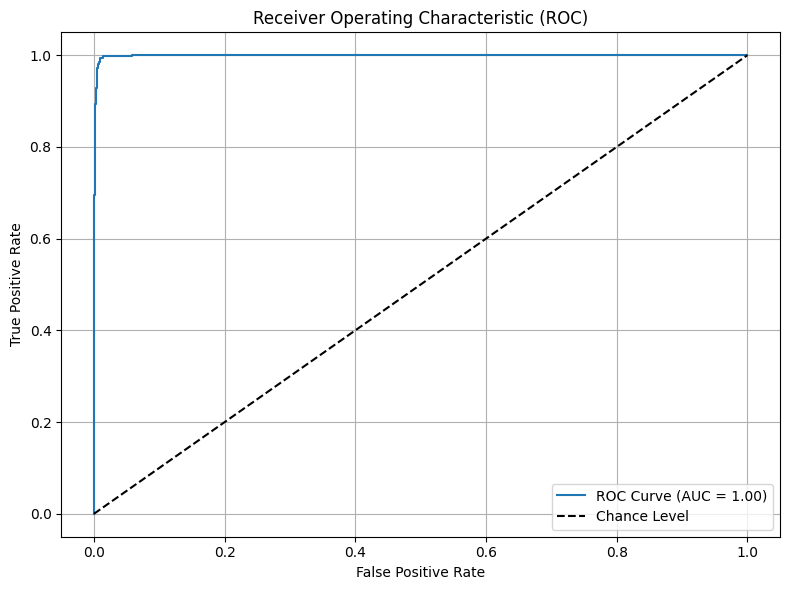

In [33]:
# Get predicted probabilities
y_pred_probs = model.predict(X_test).ravel()

# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_probs)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Chance Level')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC)")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()